# Data prepairing

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 4090


In [1]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)
  data_folder = "gdrive/MyDrive/Colab Notebooks/VK_nlp_task/"
except:
  data_folder = ""

Mounted at /content/gdrive/


In [2]:
import csv
import numpy as np
import random

data = list()

with open(data_folder + "articles_lemmatized_no_SW.csv", 'r', encoding="utf8") as file:
  csv_file = csv.reader(file)
  next(csv_file)
  for sample in csv_file:
    if len(sample[2]) == 0:
      continue
    data.append({"headline": sample[1], "body": np.array(sample[2].split()), "topic": sample[3]})

random.shuffle(data)

print("Размер выборки:", len(data))

Размер выборки: 56499


In [ ]:
import random
ind = random.randint(0, len(data) - 1)
headline, body, topic = data[ind].values()
print(f"Случайный текст:\n{topic}: {headline}.\n{' '.join(body)}")

Случайный текст:
Мир: В США упавший внедорожник убил четырех человек.
авария происходить сан-диего штат калифорний сша упавший эстакада внедорожник убивать четыре человек несколько получать ранение рассказывать телекомпания ссылка источник правоохранительный орган авария происходить автомобильный эстакада соединять сан-диего остров коронадо сообщать тасс сколько человек находиться машина пострадать неизвестно


In [3]:
import numpy as np
from math import log

vocabulary = dict()
id2tok = list()
word_cnt = 0

vocab_stats = dict()
""" vocab_stats = {
  "word" : [
    count of words in all texts,
    [count of texts containing the word, previous text where word was]
  ]
}
"""

topic_dict = dict()
topic_list = list()
topic_stat = dict()
topic_cnt = 0


for i in range(len(data)):
  headline, text, topic = data[i].values()
  if topic_dict.get(topic) is None:
    topic_dict[topic] = topic_cnt
    topic_list.append(topic)
    topic_cnt += 1
    topic_stat[topic] = 1
  else:
    topic_stat[topic] += 1

  for word in range(len(text)):
    if vocab_stats.get(text[word]) is None:
      vocab_stats[text[word]] = [1, [1, i]]
    else:
      vocab_stats[text[word]][0] += 1

      if vocab_stats[text[word]][1][1] != i:
        vocab_stats[text[word]][1][0] += 1
        vocab_stats[text[word]][1][1] = i


idf_vec = np.zeros((len(vocab_stats)))
for word in vocab_stats:
  if ((vocab_stats[word][0] <= 8 and len(word) <= 3)
      or (vocab_stats[word][0] <= 3 and len(word) <= 5)
      or (vocab_stats[word][0] <= 2)):
    pass
  else:
    vocabulary[word] = word_cnt
    idf_vec[word_cnt] = log(len(data) / vocab_stats[word][1][0])
    word_cnt += 1
    id2tok.append(word)

idf_vec = idf_vec[:len(vocabulary)]

In [4]:
def rm_rare_tokens(row):
  temp = [t for t in row["body"] if vocabulary.get(t) is not None]
  row["body"] = temp
  return row

data = list(map(rm_rare_tokens, data))
dataset = {"train": data[:int(len(data) * 0.7)],
           "valid": data[int(len(data)* 0.7): int(len(data)* 0.8)],
           "test": data[int(len(data) * 0.8):]}

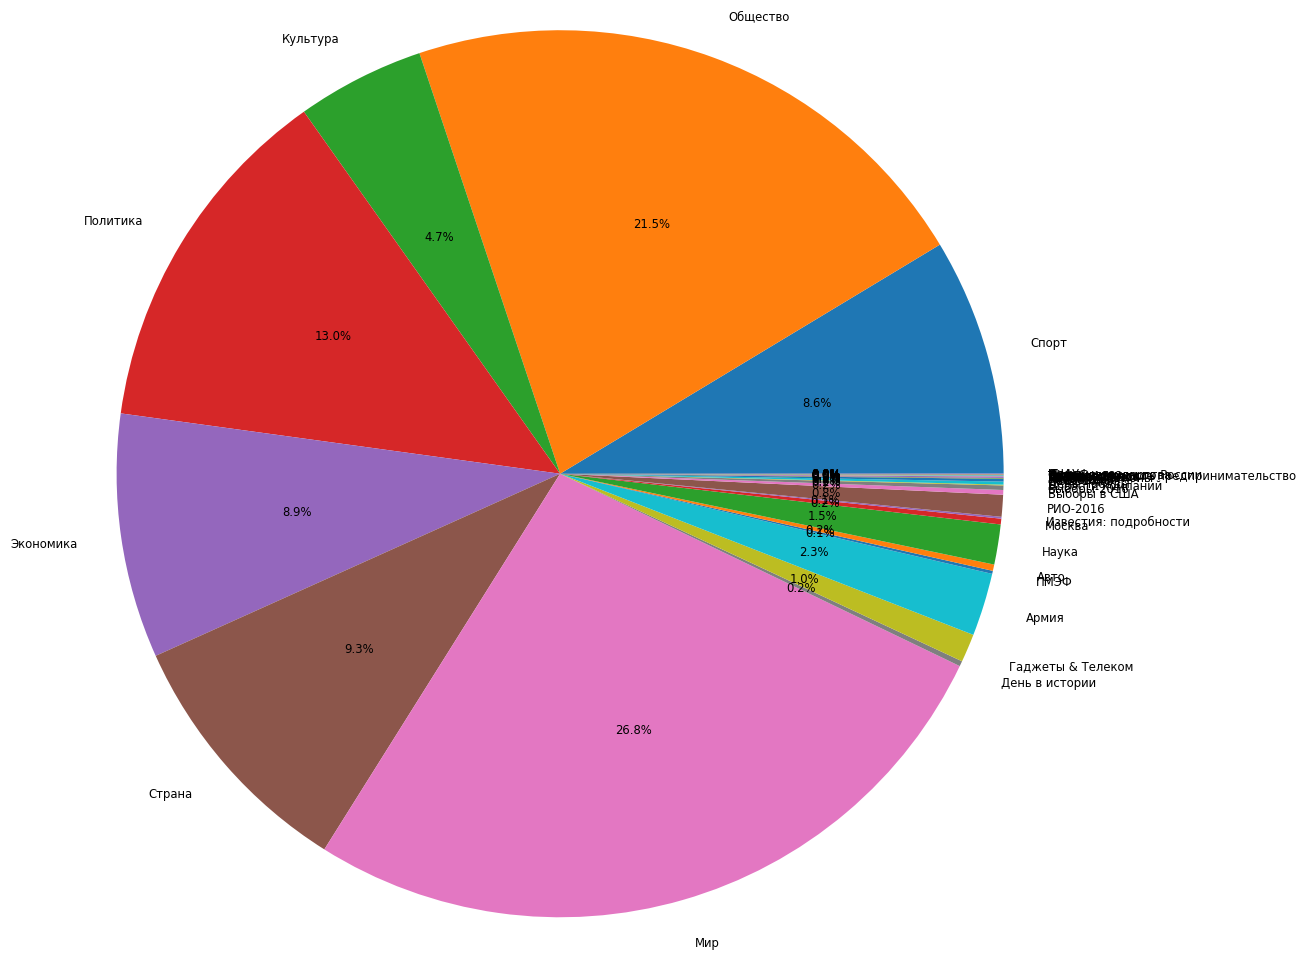

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.pie(
    topic_stat.values(),
    labels=topic_list,
    autopct='%1.1f%%',
    textprops={'size': 'smaller'},
    radius=3
    )
plt.show()

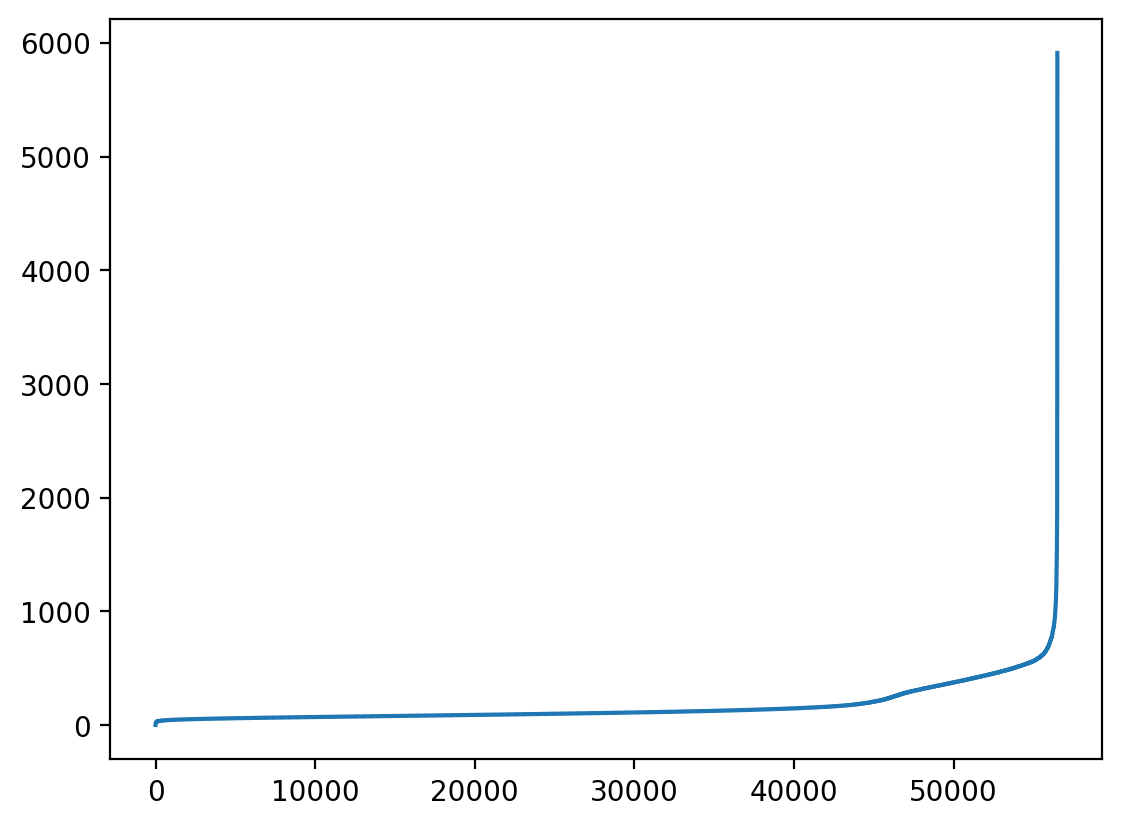

Summary:
58176 unique words & 37 unique topics(classes)
Statistics of words in texts:
Minimum: 2
Maximum: 5911
Average: 166
Median: 108


In [ ]:
import matplotlib.pyplot as plt

words_stat = list()
for i in range(len(data)):
  words_stat.append(len(data[i]["body"]))

words_stat.sort()
plt.plot(words_stat)
plt.show()
print(f"Summary:\n{len(vocabulary)} unique words & {topic_cnt} unique topics(classes)")
print(f"Statistics of words in texts:\nMinimum: {words_stat[0]}\nMaximum: {words_stat[-1]}")
print(f"Average: {sum(words_stat) // len(words_stat)}\nMedian: {words_stat[len(words_stat) // 2]}")

In [ ]:
from math import log

def one_hot_vec(word):
  ans = np.zeros((len(vocabulary)))
  ans[vocabulary[word]] += 1
  return ans


def bow(text):
  ans = np.zeros((len(vocabulary)))
  for word in text:
    ans[vocabulary[word]] += 1
  return ans


def term_frequency(text):
  bag = bow(text)
  if len(text):
    bag /= len(text)
  return bag

def tf_idf(text):
  return term_frequency(text) * idf_vec

# 1st alghoritm. Linear model (Bag of words. TF*IDF)

### Feature extracting.



In [ ]:
feature_tf_idf_vectors = dict()
feature_bow_vectors = dict()
topic_nums = dict()
train = dataset["train"]
for i in range(len(train)):
  if topic_nums.get(train[i]["topic"]) is None:
    feature_tf_idf_vectors[train[i]["topic"]] = tf_idf(train[i]["body"])
    feature_bow_vectors[train[i]["topic"]] = bow(train[i]["body"])
    topic_nums[train[i]["topic"]] = 1
  else:
    feature_tf_idf_vectors[train[i]["topic"]] += tf_idf(train[i]["body"])
    feature_bow_vectors[train[i]["topic"]] += bow(train[i]["body"])
    topic_nums[train[i]["topic"]] += 1

for topic in topic_nums:
  feature_tf_idf_vectors[topic] /= topic_nums[topic]
  feature_bow_vectors[topic] /= topic_nums[topic]

### Linear model (looking for cosine similarity)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def linear_model_predict(text2predict, func=tf_idf):
  if func == tf_idf:
    features = feature_tf_idf_vectors
  else:
    features = feature_bow_vectors

  text2predict = func(text2predict)
  ans = None
  res = -1
  cur_res = -1
  for i in features:
    cur_res = cosine_similarity(text2predict.reshape(1, -1), features[i].reshape(1, -1))
    if cur_res > res:
      res = cur_res
      ans = i
  return ans

### Results

Current best acuracy: 56.7%: 100%|██████████| 11300/11300 [21:04<00:00,  8.93it/s]


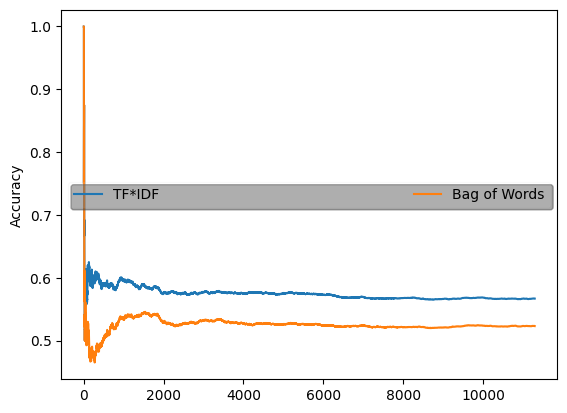


Accuracy of linear model:
	- using tf*idf: 56.69%
	- using bag of words: 52.32%


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

acc_tf_idf = 0
acc_bow = 0

test = dataset["test"]
pbar = tqdm(range(len(test)))
acc_hist = list()
for i in pbar:
  tf_idf_pred = linear_model_predict(test[i]["body"], tf_idf)
  bow_pred = linear_model_predict(test[i]["body"], bow)
  acc_tf_idf += tf_idf_pred == test[i]["topic"]
  acc_bow += bow_pred == test[i]["topic"]

  if (not (i % 100)):
    pbar.set_description(f"Current best acuracy: {round(100 * max(acc_tf_idf, acc_bow) / (i + 1), 1)}%")
  acc_hist.append((acc_tf_idf / (i + 1), acc_bow / (i + 1)))

plt.plot(acc_hist, label=("TF*IDF", "Bag of Words"))
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.1)
plt.ylabel("Accuracy")
plt.show()

acc_tf_idf /= len(test)
acc_bow /= len(test)
print(f"\nAccuracy of linear model:\n\t- using tf*idf: {round(100 * acc_tf_idf, 2 )}%")
print(f"\t- using bag of words: {round(100 * acc_bow, 2)}%")

Использование метода TF*IDF для извлечения признаков показало лучшие результаты, что было ожидаемо, ведь этот метод оценивает важность слов, чего не делает Bag of words. В целом результаты работы этого алгоритма не дали особо хорошего результата, но можно сказать, что он работает, учитывая случайный результат в 1/37 = 2.7%. Могу предположить, что подобный алгоритм более уместен, когда стоит задача классификации с небольшим количество классов(спам/не спам, позитивный текст или нет), и порядок слов не играет большую роль.

# Word to vector

Прежде чем переходить к сверточным и рекурентым сетям, необходимо уменьшить векторное представление слов, для этого я буду использовать метод word to vector и skipgram.

### Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
  def __init__(self, dataset, wsize=3):
    self.data = list()
    for sample in range(len(dataset)):
        text = dataset[sample]['body']
        for i, wd in enumerate(text):
          target = vocabulary[wd]
          window = [i+j for j in
                    range(-wsize, wsize+1, 1)
                    if (i+j>=0) &
                      (i+j<len(text)) &
                      (j!=0)]

          self.data += [(target, vocabulary[text[w]]) for w in window]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
BATCH_SIZE = 4096
N_LOADER_PROCS = 0

dataloader = dict()
for key in dataset.keys():
  dataloader[key] = DataLoader(Word2VecDataset(dataset[key]),
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=N_LOADER_PROCS)

### Word2vector model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input)
        logits = self.expand(hidden)
        return logits

In [ ]:
EMBED_SIZE = 300

w2v_model = Word2Vec(len(vocabulary), EMBED_SIZE)

try:
  w2v_model.load_state_dict(torch.load(data_folder + "word2vec.pth"))
except:
  pass

LR = 0.1
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(w2v_model.parameters(), lr=LR)

### Training the model

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = w2v_model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    progress_bar.set_description(f"Epoch - {epoch} Loss - {epoch_loss}")
    running_loss.append(epoch_loss)
    torch.save(w2v_model.state_dict(), data_folder + "word2vec.pth")

Epoch - 9 Loss - 20.304280354785867: 100%|██████████| 110220/110220 [56:41<00:00, 38.51it/s] 

In [ ]:
LR = 0.01
EPOCHS = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(w2v_model.parameters(), lr=LR)
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = w2v_model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    progress_bar.set_description(f"Epoch - {epoch} Loss - {epoch_loss}")
    running_loss.append(epoch_loss)
    torch.save(w2v_model.state_dict(), data_folder + "word2vec.pth")

Epoch - 9 Loss - 20.304280354785867: 100%|██████████| 110220/110220 [56:41<00:00, 32.40it/s]


In [ ]:
LR = 0.001
EPOCHS = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(w2v_model.parameters(), lr=LR)
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = w2v_model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    progress_bar.set_description(f"Epoch - {epoch} Loss - {epoch_loss}")
    running_loss.append(epoch_loss)
    torch.save(w2v_model.state_dict(), data_folder + "word2vec.pth")

Epoch - 29 Loss - 7.460259013849991: 100%|██████████| 330660/330660 [2:49:52<00:00, 38.35it/s]   

In [ ]:
LR = 0.0001
EPOCHS = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(w2v_model.parameters(), lr=LR)
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = w2v_model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    progress_bar.set_description(f"Epoch - {epoch} Loss - {epoch_loss}")
    running_loss.append(epoch_loss)
    torch.save(w2v_model.state_dict(), data_folder + "word2vec.pth")

Epoch - 29 Loss - 7.460259013849991: 100%|██████████| 330660/330660 [2:49:52<00:00, 32.44it/s]


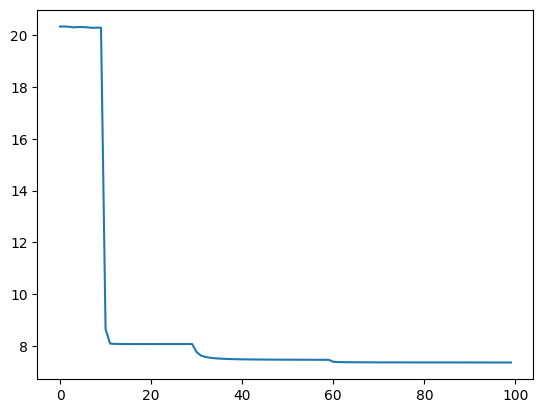

In [ ]:
import matplotlib.pyplot as plt

plt.plot(running_loss)
plt.show()

### Results

In [ ]:
embeddings = w2v_model.embed.weight.to('cpu').data.numpy()

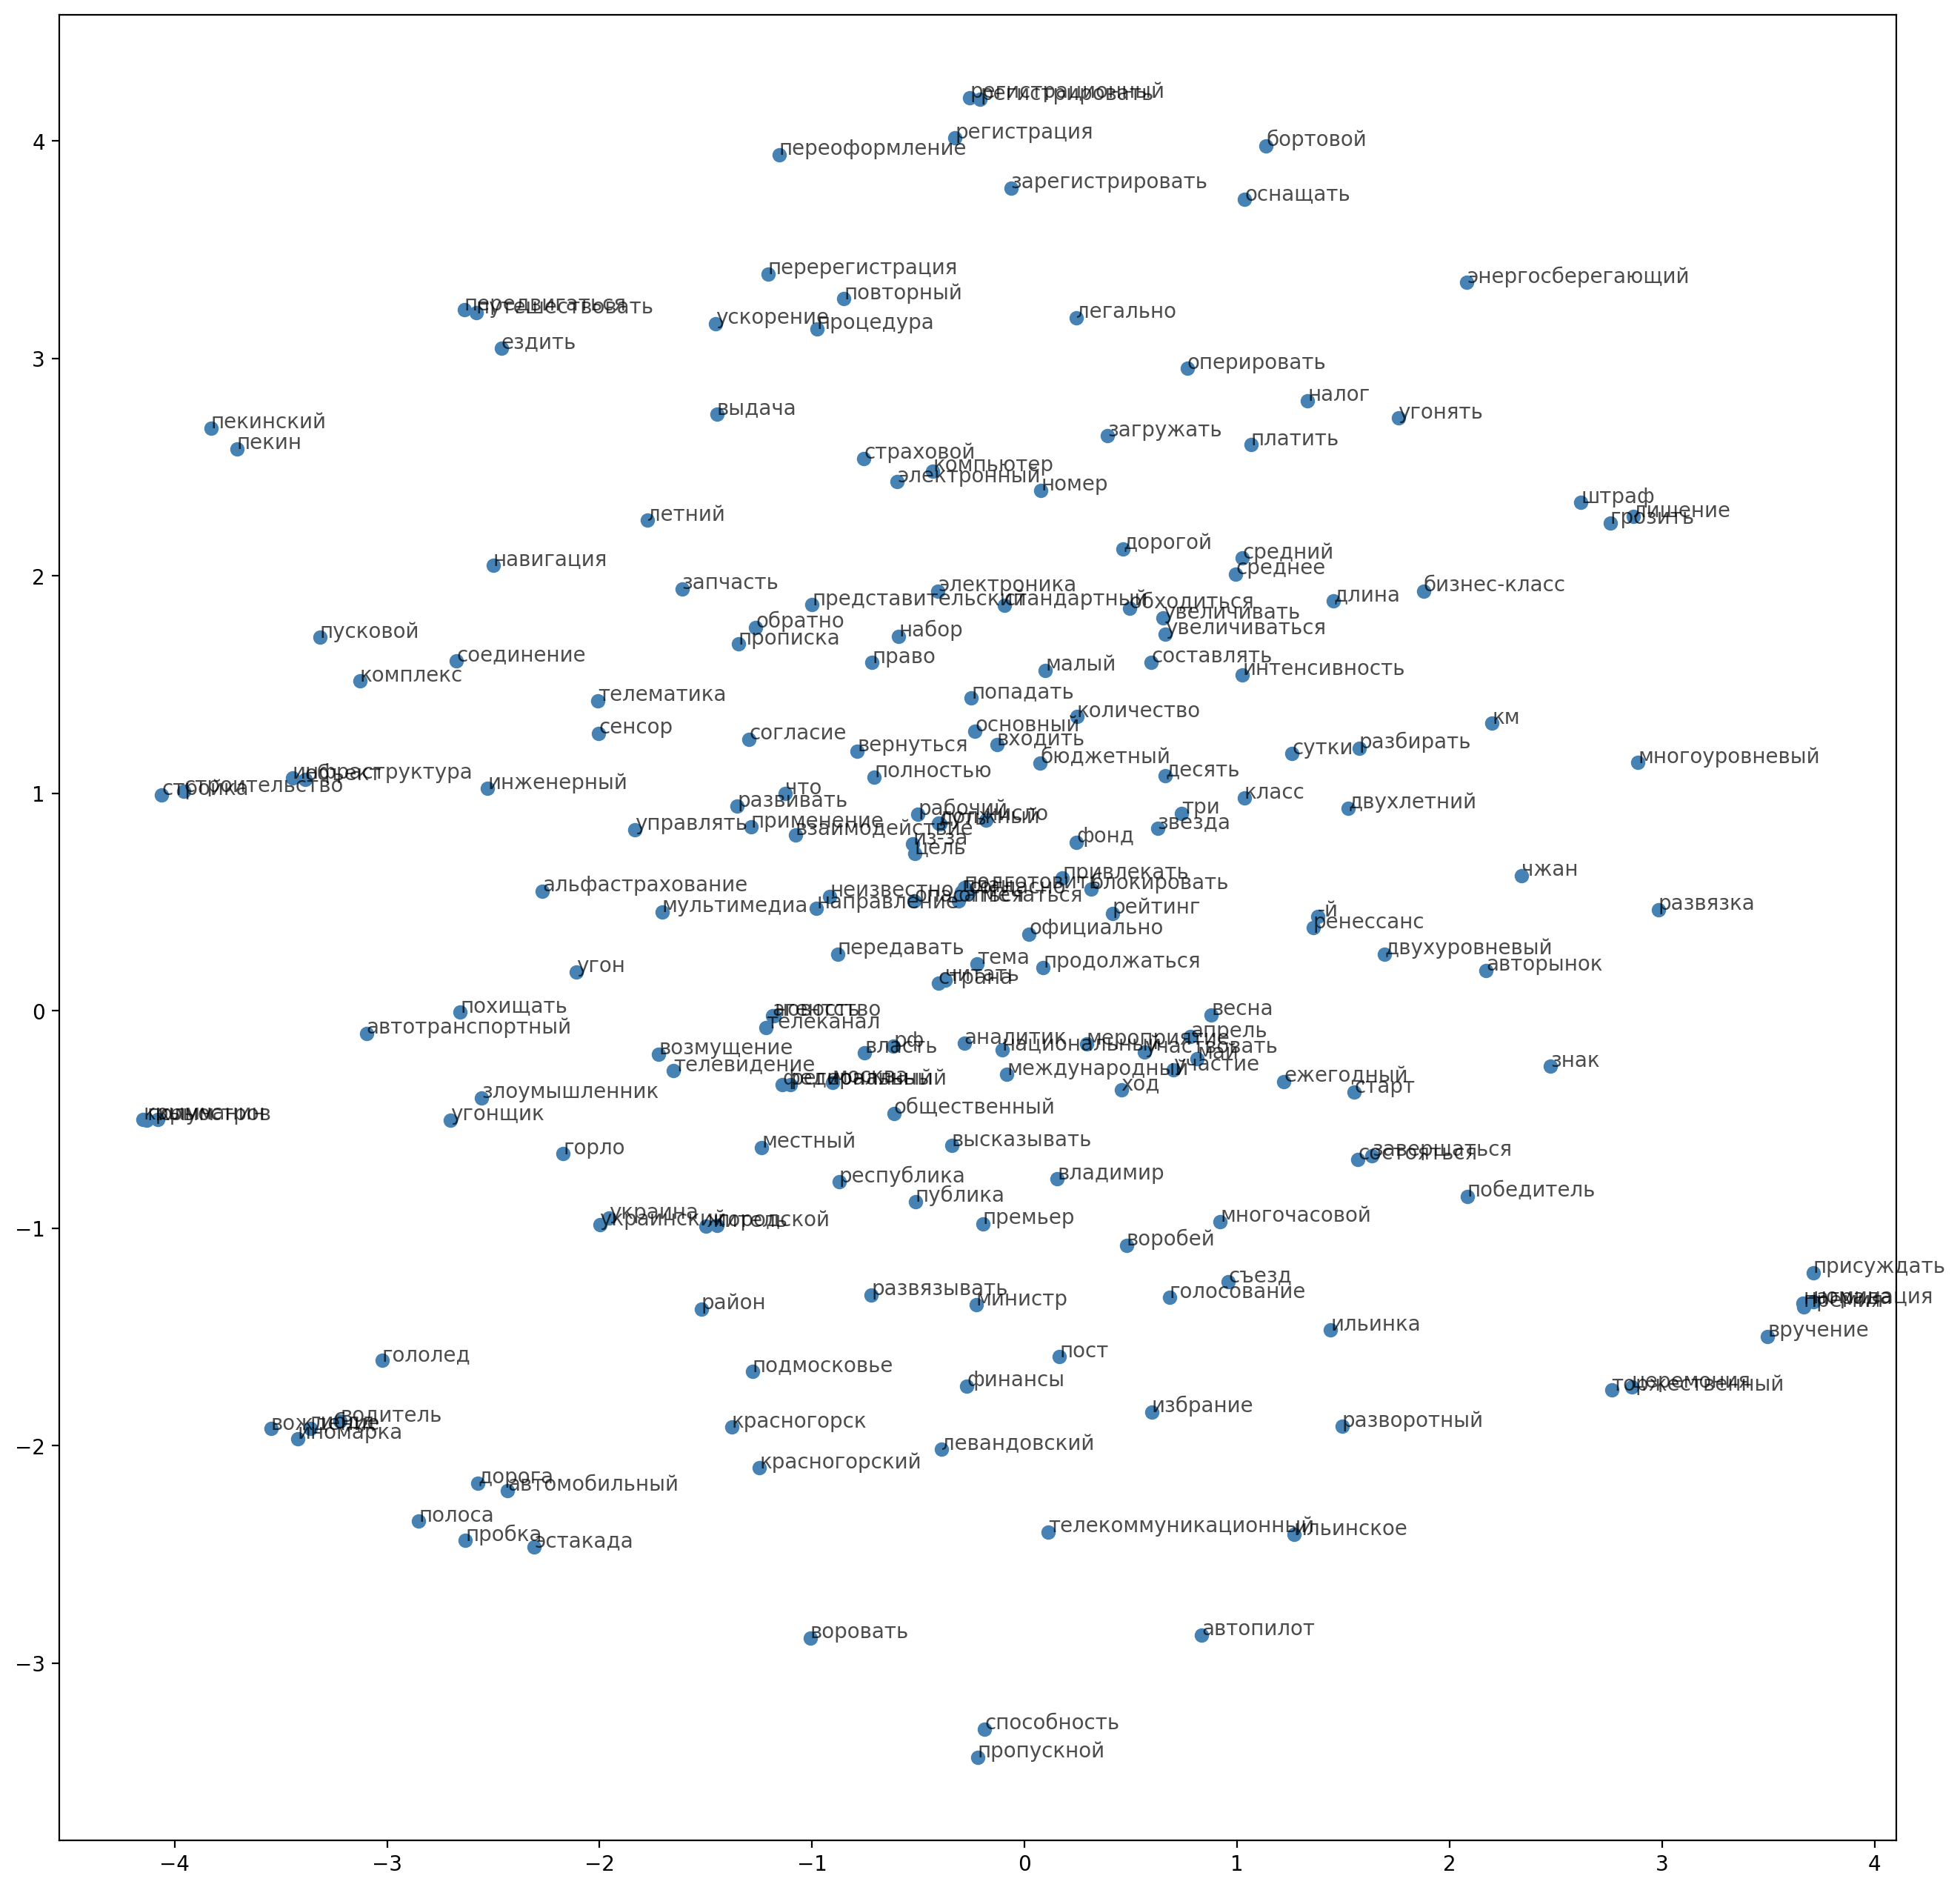

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
viz_words = 200
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[1000:1000+viz_words, :])
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(id2tok[idx + 1000], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
plt.savefig(data_folder + 'word2vec.png')

Нормально оценить работу данного алгоритма скорее всего нельзя, поскольку слова могут иметь много разных смыслов, и соответственно могут быть использованы в разных контекстах, но чтобы хоть как-то оценить работу алгоритма выше представлено изображение, на котором полученные вектора отображены на двумерное пространство. Могу точно сказать, что нейросеть научилась определять контекст лучше чем случайно - можно легко найти отдельные кластеры близких по смыслу слов: "дорога - автомобильный - полоса - пробка - эстакада", "красногорск - красногорский - подмосковье" и т.д.

In [ ]:
EMBED_SIZE = 300
w2v_model = Word2Vec(len(vocabulary), EMBED_SIZE)
w2v_model.load_state_dict(torch.load(data_folder + "word2vec.pth"))
word2vec = w2v_model.embed.weight.to("cpu").data

# 2nd algorithm. LSTM (RNN)

### Dataloader

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)


def get_inputs(dataset, set_type="train"):
  input = list()
  for i in range(len(dataset[set_type])):
    text = list()
    for j in range(len(dataset[set_type][i]["body"])):
      text.append(vocabulary[dataset[set_type][i]["body"][j]])
    input.append(np.array(text))
  return np.array(input, dtype=object)

def get_labels(dataset, set_type="train"):
  label = np.zeros((len(dataset[set_type])))
  for i in range(len(dataset[set_type])):
    label[i] = topic_dict[dataset[set_type][i]["topic"]]
  return label


class CustomDataset(Dataset):
    def __init__(self, dataset, set_type):
        self.input_data = get_inputs(dataset, set_type)
        self.target_data = get_labels(dataset, set_type)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]


In [ ]:
batch_size = 1
train_dataloader = DataLoader(CustomDataset(dataset, "train"), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(CustomDataset(dataset, "valid"), batch_size=batch_size, shuffle=True)

### LSTM model

In [ ]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self,
                 pretrained_embedding,
                 hidden_dim,
                 num_classes=37,
                 dropout=0.5):

        super(LSTM,self).__init__()

        # Embedding layer converts integer sequences to vector sequences
        self.vocab_size, self.embed_dim = pretrained_embedding.shape
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=True)

        # LSTM layer process the vector sequences
        self.lstm = nn.LSTM(self.embed_dim,
                            hidden_dim,
                            num_layers = 2,
                            dropout = dropout,
                            batch_first = True
                           )

        # Dense layer to predict
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(p=dropout)


    def forward(self,text):
        embedded = self.embedding(text)

        # Thanks to packing, LSTM don't see padding tokens
        # and this makes our model better
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded,
            torch.tensor(np.array([len(text[0])])).cpu(),
            batch_first=True)

        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        logits = self.fc(self.dropout(hidden))

        return logits


In [ ]:
import torch.optim as optim

def initilize_model(pretrained_embedding,
                    hidden_dim,
                    num_classes=37,
                    dropout=0.5,
                    learning_rate=0.01):

    rnn_model = LSTM(pretrained_embedding=pretrained_embedding,
                        hidden_dim=hidden_dim,
                        num_classes=num_classes,
                        dropout=dropout)

    # Send model to `device` (GPU/CPU)
    rnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(rnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return rnn_model, optimizer

In [ ]:
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), data_folder + "best_lstm_model.pth")


            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Training the model

In [ ]:
lstm_rand, optimizer = initilize_model(pretrained_embedding=word2vec,
                                      hidden_dim=1024,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(lstm_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.747514   |  1.234085  |   62.83   |  436.33  
   2    |   1.217380   |  1.062134  |   69.75   |  461.36  
   3    |   1.040008   |  1.112422  |   72.00   |  494.71  
   4    |   0.924008   |  0.998878  |   73.01   |  512.56  
   5    |   0.796247   |  1.107871  |   72.37   |  478.22  
   6    |   0.644688   |  1.297647  |   72.80   |  492.64  
   7    |   0.498909   |  1.513094  |   73.72   |  502.09  
   8    |   0.365363   |  1.816989  |   74.41   |  450.58  
   9    |   0.273274   |  1.950490  |   71.66   |  424.39  
  10    |   0.220973   |  2.260122  |   73.81   |  421.38  
  11    |   0.174979   |  2.490059  |   72.88   |  431.84  
  12    |   0.139113   |  2.545139  |   73.77   |  426.73  
  13    |   0.116230   |  2.755520  |   74.05   |  425.20  
  14    |   0.097975   |  2.847023  |   74.04   |  425.29  
  15    |   0.073790

### Results

In [ ]:
lstm_model = LSTM(word2vec, 1024)
lstm_model.load_state_dict(torch.load(data_folder + "best_lstm_model.pth"))
lstm_model = lstm_model.to(device)

In [ ]:
test_dataloader = DataLoader(CustomDataset(dataset, "test"), batch_size=1)

test_loss, test_accuracy = evaluate(lstm_rand, test_dataloader)

print(f"Accuracy of LSTM model on test dataset is {test_accuracy}%")

Accuracy of LSTM model on test dataset is 74.17699115044248%


Эта модель показала достаточно хорошие результаты, с учетом возможности настроить гиперпараметры и дообучить модель. Но у меня не получилось нормально реализовать dataloader из-за различных длинн текста и скорого дедлайна. Вообще, представленная модель имеет простую архитектуру, при этом она получилась довольно громоздкой, что не очень хорошо, если решать эту задачу для реального применения, где очень важен результат и используемые ресурсы. Кроме того, рекурентные сети в области nlp чаще применяются для генерации текста, а не для классификации.

# 3rd algorithm. CNN

### Dataloader

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def get_inputs(dataset, set_type="train"):
  input = np.zeros((len(dataset[set_type]), 500))
  for i in range(len(dataset[set_type])):
    for j in range(min(500, len(dataset[set_type][i]["body"]))):
      input[i][j] = vocabulary[dataset[set_type][i]["body"][j]]
  return input

def get_labels(dataset, set_type="train"):
  label = np.zeros((len(dataset[set_type])))
  for i in range(len(dataset[set_type])):
    if len(dataset[set_type][i]["body"]) <= 500:
      pass
    else:
      continue
    label[i] = topic_dict[dataset[set_type][i]["topic"]]
  return label

def data_loader(dataset,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs = torch.tensor(get_inputs(dataset, "train"))
    val_inputs = torch.tensor(get_inputs(dataset, "valid"))
    train_labels = torch.tensor(get_labels(dataset, "train"))
    val_labels = torch.tensor(get_labels(dataset, "valid"))

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(dataset, batch_size=50)

### CNN model

Я буду использовать такую архитектуру, она довольно простая, но ее хватит для наших целей
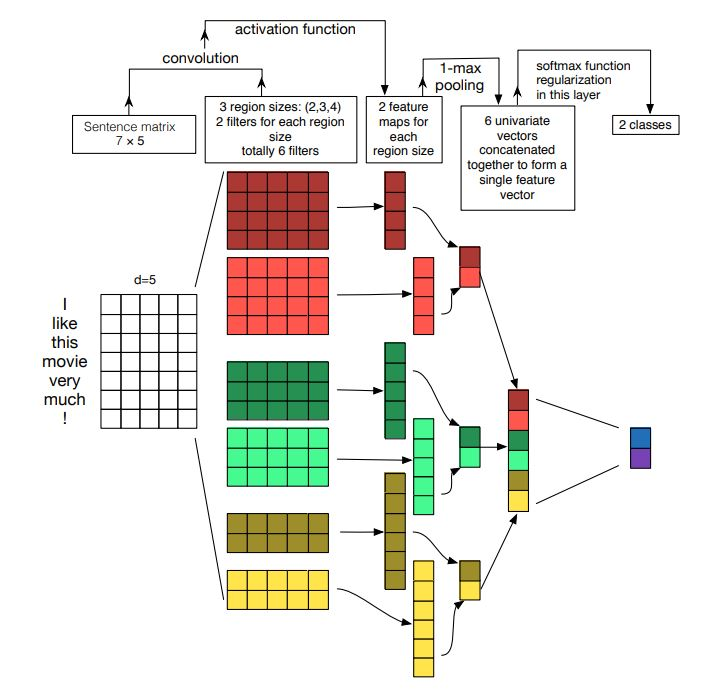

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convolational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 filter_sizes=[3, 4, 5],
                 num_filters=[500, 500, 500],
                 num_classes=37,
                 dropout=0.5):

        super(CNN_NLP, self).__init__()
        # Embedding layer
        self.vocab_size, self.embed_dim = pretrained_embedding.shape
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=False)

        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    filter_sizes=[3, 4, 5],
                    num_filters=[500, 500, 500],
                    num_classes=37,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), data_folder + "best_cnn_model.pth")


            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device).long() for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Training the model

In [ ]:
cnn_model, optimizer = initilize_model(pretrained_embedding=word2vec,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_model, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.357110   |  0.947429  |   68.25   |   10.71  
   2    |   0.825668   |  0.780820  |   73.82   |   10.69  
   3    |   0.625092   |  0.738900  |   75.15   |   10.80  
   4    |   0.468725   |  0.700399  |   76.05   |   10.87  
   5    |   0.338218   |  0.707629  |   76.94   |   10.92  
   6    |   0.242468   |  0.730970  |   77.15   |   10.80  
   7    |   0.175542   |  0.826307  |   76.02   |   10.65  
   8    |   0.133964   |  0.958163  |   73.81   |   10.69  
   9    |   0.104393   |  0.838287  |   76.80   |   10.77  
  10    |   0.085050   |  0.826654  |   76.94   |   10.65  
  11    |   0.070380   |  0.856623  |   77.31   |   10.74  
  12    |   0.059944   |  0.866884  |   76.85   |   10.63  
  13    |   0.050221   |  0.944892  |   76.44   |   10.67  
  14    |   0.044546   |  0.936173  |   77.27   |   10.56  
  15    |   0.038330

In [ ]:
optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=0.01,
                               rho=0.95)
train(cnn_model, optimizer, train_dataloader, val_dataloader)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.016883   |  0.989932  |   77.43   |   10.78  
   2    |   0.018082   |  0.986044  |   77.61   |   10.79  
   3    |   0.017385   |  0.994137  |   77.61   |   10.74  
   4    |   0.016615   |  0.989081  |   77.65   |   10.75  
   5    |   0.015806   |  0.993081  |   77.70   |   10.67  
   6    |   0.016172   |  0.992129  |   77.54   |   10.57  
   7    |   0.014452   |  0.992709  |   77.61   |   10.64  
   8    |   0.014196   |  0.995507  |   77.59   |   10.80  
   9    |   0.014413   |  0.992711  |   77.72   |   10.83  
  10    |   0.014043   |  0.997869  |   77.52   |   10.69  


Training complete! Best accuracy: 77.72%.


In [ ]:
cnn_model = CNN_NLP(word2vec)
cnn_model.load_state_dict(torch.load(data_folder + "best_cnn_model.pth"))
cnn_model = cnn_model.to(device)

### Results

In [ ]:
test_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(get_inputs(dataset, "test")),
        torch.tensor(get_labels(dataset, "test"))
        ),
    batch_size=50)

test_loss, test_accuracy = evaluate(cnn_model, test_dataloader)

print(f"Accuracy of CNN model on test dataset is {test_accuracy}%")

Accuracy of CNN model on test dataset is 77.58407079646018%


Данная модель показала лучшие результаты, при этом она довольно простая и быстро обучается. Я считаю, этот алгоритм лучше всего подходит для решения данной задачи, кроме того можно легко добиться более высоких результатов, если настроить гиперпараметры и дообучить модель. Еще нужно реализовать учет отсеченной части текста, сейчас все тексты отсекаются или добавляются до 500 слов из-за нехватки памяти.